In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False  

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
# 加载新的 Excel 文件
file_path = 'data_input_auto/WTI月差预测.xlsx'
excel_data = pd.ExcelFile(file_path)
sheet = excel_data.parse('Sheet1')
sheet.rename(columns={'DataTime': 'Date'}, inplace=True)
sheet['Date'] = pd.to_datetime(sheet['Date'], errors='coerce')
sheet.set_index('Date', inplace=True)
sheet = sheet.rename(columns={'WTI M1-M4':'WTI连1-连4月差'})
sheet.tail()

,WTI连1-连4月差
Date,
2025-07-21,2.78
2025-07-22,2.32
2025-07-23,1.66
2025-07-24,2.00
2025-07-25,1.84


In [5]:
sheet1 = pd.ExcelFile('eta/美国RBOB汽油裂解_合并数据.xlsx').parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1 = sheet1.drop(columns=['实际值'])
sheet1 = sheet1.dropna()
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1.set_index('Date', inplace=True)


merged_data = sheet.join(sheet1[['美国RBOB汽油裂解']], how='outer')
merged_data.reset_index(inplace=True)
merged_data.rename(columns={'index': 'Date'}, inplace=True)
merged_data.tail()

,Date,WTI连1-连4月差,美国RBOB汽油裂解
3454,2025-08-18,NaN,16.98
3455,2025-08-19,NaN,15.82
3456,2025-08-20,NaN,15.96
3457,2025-08-21,NaN,15.96
3458,2025-08-22,NaN,15.89


In [6]:
file_path2  = 'eta/WTI_M1-M4拟合残差_美国RBOB汽油裂解_合并数据.xlsx'
sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
# 将真实值和预测值列合并为一个列
sheet2['WTI M1-M4拟合残差/美国RBOB汽油裂解'] = sheet2['真实值'].fillna(sheet2['预测值'])
# 删除原始的真实值和预测值列
sheet2 = sheet2.drop(columns=['真实值', '预测值'])
sheet2 = sheet2.sort_values(by='Date', ascending=True)
sheet2.head()

,Date,WTI M1-M4拟合残差/美国RBOB汽油裂解
225,2024-10-01,1.2793
224,2024-10-02,1.2102
223,2024-10-03,1.4166
222,2024-10-04,1.9308
221,2024-10-07,1.9034


In [7]:
# 合并得到所有数据
sheet_daily = pd.merge(merged_data, sheet2, on='Date', how='left')
sheet_daily = sheet_daily[sheet_daily['Date'] >= '2024-01-01']
last_day = sheet_daily['Date'][sheet_daily['WTI连1-连4月差'].last_valid_index()]
sheet_daily = sheet_daily[~((sheet_daily['Date'] < last_day) & (sheet_daily['WTI连1-连4月差'].isna()))]
sheet_daily.tail()

,Date,WTI连1-连4月差,美国RBOB汽油裂解,WTI M1-M4拟合残差/美国RBOB汽油裂解
3454,2025-08-18,NaN,16.98,0.5802
3455,2025-08-19,NaN,15.82,0.5767
3456,2025-08-20,NaN,15.96,0.5732
3457,2025-08-21,NaN,15.96,0.5696
3458,2025-08-22,NaN,15.89,0.5661


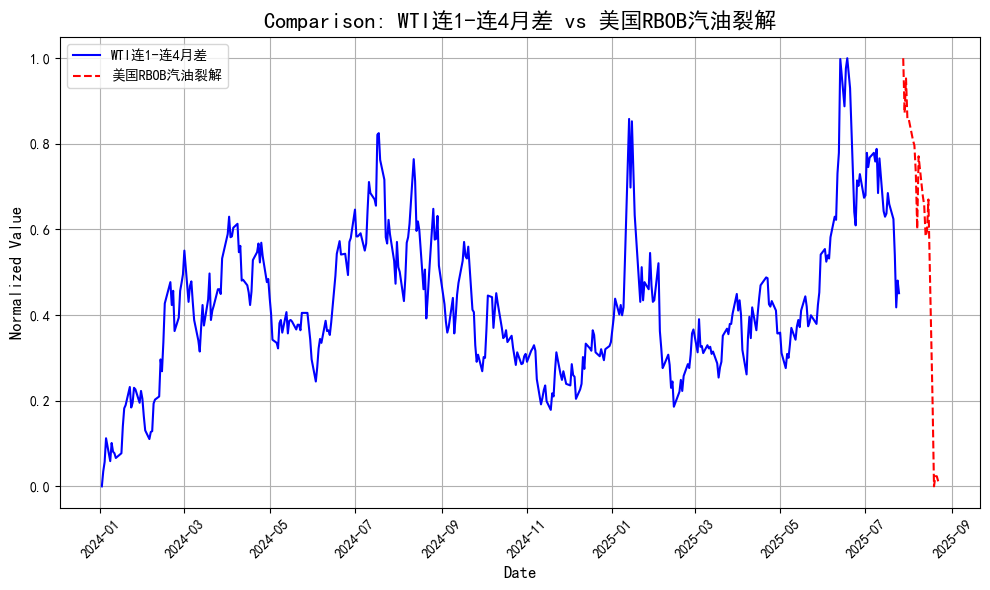

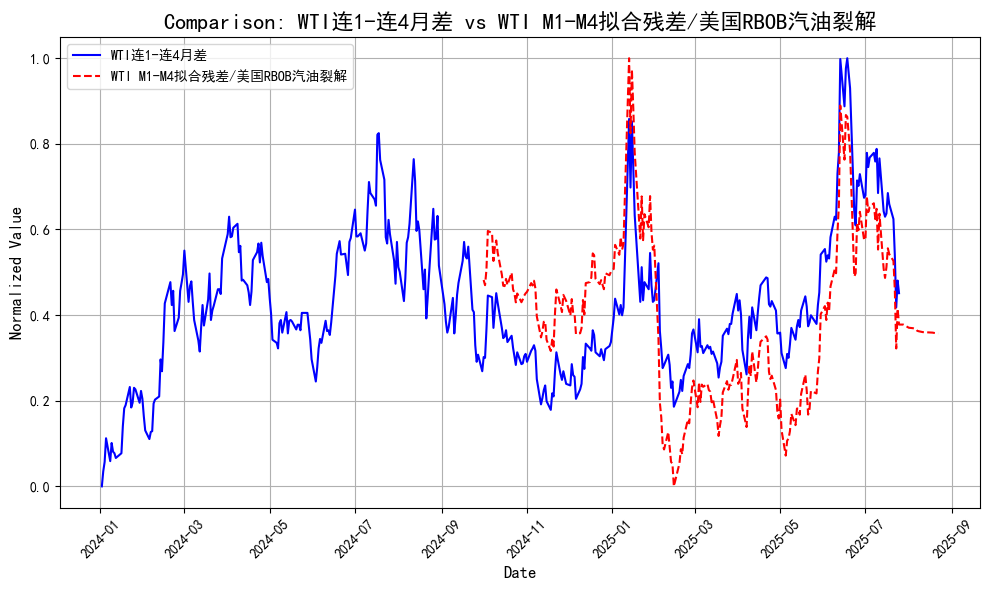

In [8]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='WTI连1-连4月差', 
    compare_cols=['美国RBOB汽油裂解','WTI M1-M4拟合残差/美国RBOB汽油裂解']
)

---

In [9]:
sheet_daily['WTI连1-连4月差_预测'] =  0.1477* sheet_daily['美国RBOB汽油裂解'] -2.0622 + sheet_daily['WTI M1-M4拟合残差/美国RBOB汽油裂解'] - 0.18
sheet_daily.tail()

,Date,WTI连1-连4月差,美国RBOB汽油裂解,WTI M1-M4拟合残差/美国RBOB汽油裂解,WTI连1-连4月差_预测
3454,2025-08-18,NaN,16.98,0.5802,0.845946
3455,2025-08-19,NaN,15.82,0.5767,0.671114
3456,2025-08-20,NaN,15.96,0.5732,0.688292
3457,2025-08-21,NaN,15.96,0.5696,0.684692
3458,2025-08-22,NaN,15.89,0.5661,0.670853


In [10]:
# 创建每日数据框
merged_df_daily = pd.DataFrame()
merged_df_daily['Date'] = sheet_daily['Date']
merged_df_daily['真实值'] = sheet_daily['WTI连1-连4月差']
merged_df_daily['预测值'] = None

# 在last_day之后填充预测值
mask = merged_df_daily['Date'] > last_day
merged_df_daily.loc[mask, '预测值'] = sheet_daily.loc[mask, 'WTI连1-连4月差_预测']

# 创建月度数据框 
merged_df_montly = pd.DataFrame()
merged_df_montly['Date'] = sheet_daily['Date']
merged_df_montly['真实值'] = sheet_daily['WTI连1-连4月差']
merged_df_montly['预测值'] = None

# 在2024-01-01之后填充预测值
mask = merged_df_montly['Date'] > '2024-01-01'
merged_df_montly.loc[mask, '预测值'] = sheet_daily.loc[mask, 'WTI连1-连4月差_预测']

In [11]:
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/WTI连1-连4月差_合并数据.xlsx', index=False,float_format='%.4f')
merged_df_daily

,Date,真实值,预测值
3458,2025/08/22,NaN,0.670853
3457,2025/08/21,NaN,0.684692
3456,2025/08/20,NaN,0.688292
3455,2025/08/19,NaN,0.671114
3454,2025/08/18,NaN,0.845946
...,...,...,...
3049,2024/01/08,-0.29,None
3048,2024/01/05,0.00,None
3047,2024/01/04,-0.30,None
3046,2024/01/03,-0.42,None


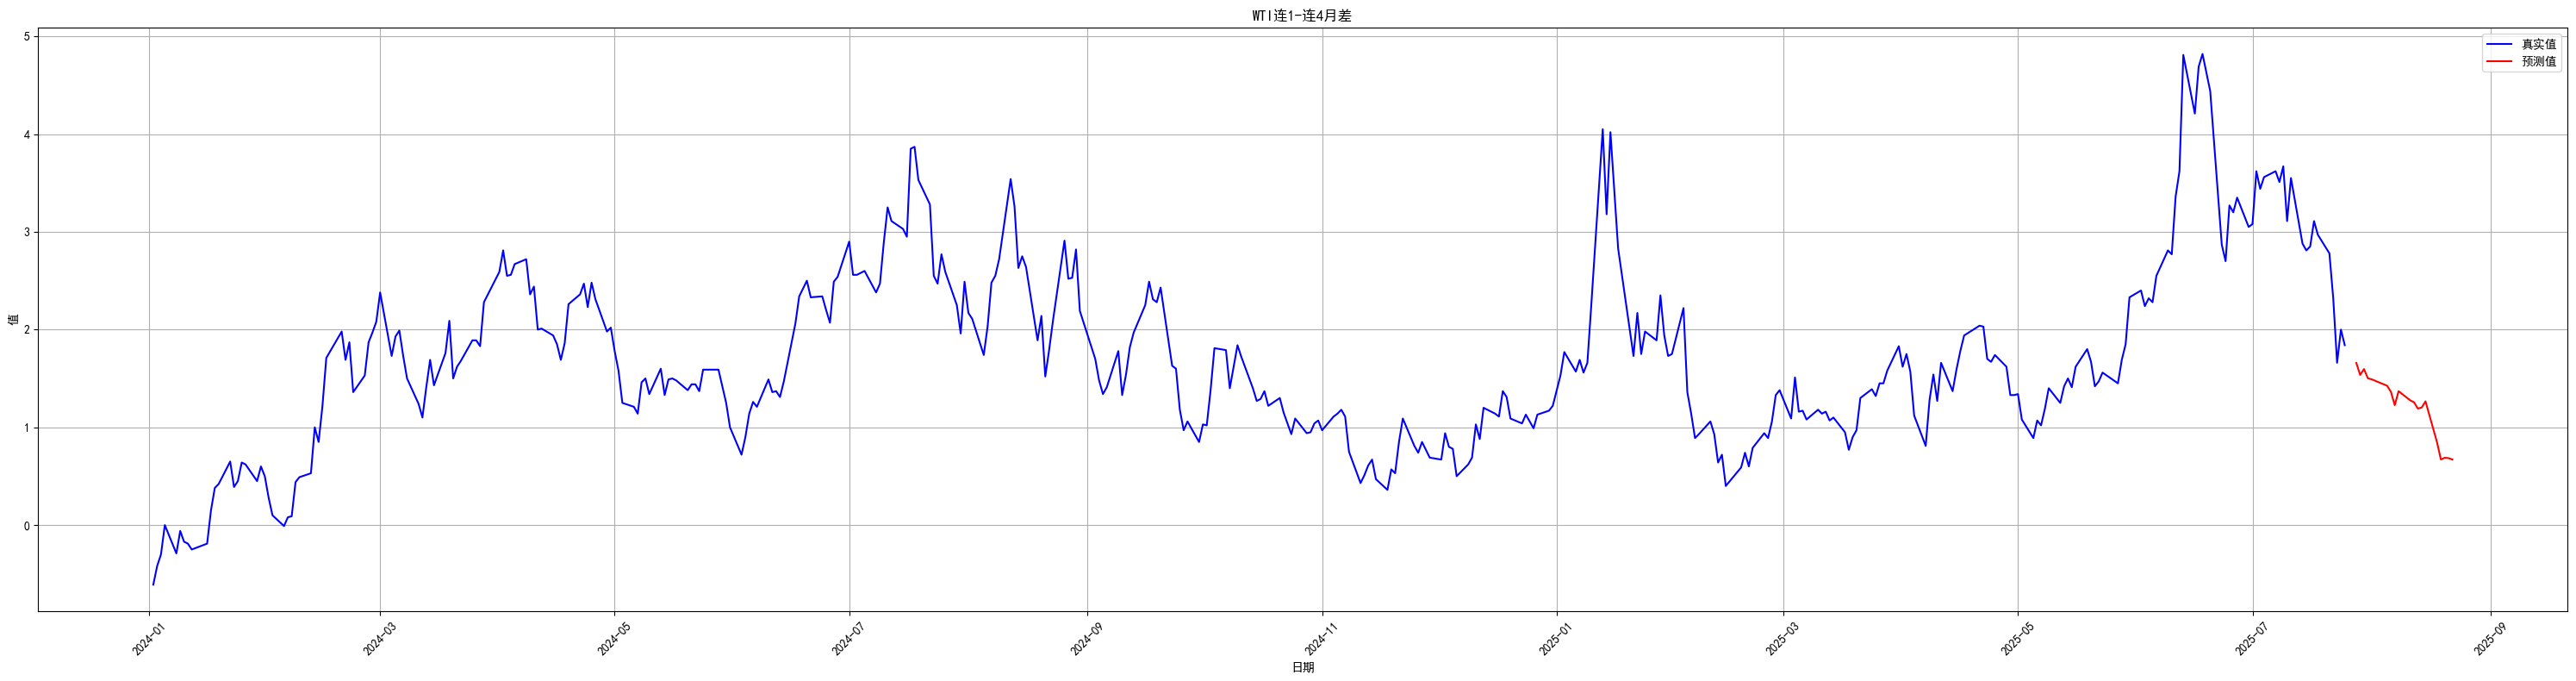

In [12]:
# 设置图形大小
plt.figure(figsize=(30, 8))




merged_df_daily_plot = merged_df_daily
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])

plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['真实值'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['预测值'], color='red', label='预测值')

avline_date = pd.to_datetime(last_day)
#plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()
plt.title('WTI连1-连4月差')
plt.xlabel('日期')
plt.ylabel('值')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
merged_df_montly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_montly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/WTI连1-连4月差_月度数据.xlsx', index=False,float_format= '%.4f')
merged_df_monthly.head()

,Date,真实值,预测值
19,2025/08/31,NaN,1.129579
18,2025/07/31,2.967368,1.573239
17,2025/06/30,3.288000,NaN
16,2025/05/31,1.449048,NaN
15,2025/04/30,1.560000,NaN


---

In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.WTI_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "WTI连1-连4月差"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Lcel import update_excel_data
file_path = "eta/1.WTI_数据上传.xlsx"
sheet_name = "详情页"
identifier = "WTI连1-连4月差"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/07/31)
数据已成功更新到Excel文件
